In [17]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [18]:
from langgraph.prebuilt import create_react_agent
from utils import get_llm
llm = get_llm()

In [19]:
FAQ_DATA = {
    "refund policy": "Customers can request a refund within 30 days of purchase, subject to approval",
    "support email": "You can reach support at support@qt.com"
}


customers = {
    "rahul.sharma@example.com": {
        "name": "Rahul Sharma",
        "age": 29,
        "location": "Mumbai, India",
        "interests": ["gaming", "cricket", "fitness"],
        "premium_member": True
    },
    "sneha.reddy@example.com": {
        "name": "Sneha Reddy",
        "age": 34,
        "location": "Hyderabad, India",
        "interests": ["cooking", "yoga", "travel"],
        "premium_member": False
    },
    "arjun.mehta@example.com": {
        "name": "Arjun Mehta",
        "age": 41,
        "location": "Bangalore, India",
        "interests": ["technology", "startups", "reading"],
        "premium_member": True
    },
    "fatima.khan@example.com": {
        "name": "Fatima Khan",
        "age": 27,
        "location": "Delhi, India",
        "interests": ["fashion", "blogging", "photography"],
        "premium_member": False
    },
    "vijay.patel@example.com": {
        "name": "Vijay Patel",
        "age": 38,
        "location": "Ahmedabad, India",
        "interests": ["finance", "investing", "travel"],
        "premium_member": True
    }
}

In [20]:
from langchain.tools import tool

@tool
def get_customer(email: str):
    """
    Retrieve customer information by email.

    This tool looks up a customer's details in the `customers` dictionary
    using the provided email as the key.

    Args:
        email (str): The customer's email address.

    Returns:
        dict | str: The customer's information if found, otherwise
        the string "Not Found".

    Example:
        >>> get_customer("rahul.sharma@example.com")
        {'name': 'Rahul Sharma', 'age': 29, ...}

        >>> get_customer("unknown@example.com")
        'Not Found'
    """
    return customers.get(email, 'Not Found')

In [21]:
@tool
def internal_kb(topic: str):
    """
    Retrieve information from the internal FAQ knowledge base.

    This function looks up a given topic in a predefined FAQ dictionary
    and returns the corresponding information. The lookup is case-insensitive.

    Args:
        topic (str): The topic to search for within the FAQ.
            Example: "refund policy", "support email".

    Returns:
        str: The information associated with the topic if found; otherwise,
        the string "unknown topic".

    Example:
        >>> internal_kb("refund policy")
        'Customers can get refund with in 30 days of purchase'

        >>> internal_kb("SUPPORT EMAIL")
        'support@qt.com'

        >>> internal_kb("warranty")
        'unknown topic'
    """
    return FAQ_DATA.get(topic.lower(), 'unknown topic')

In [22]:
@tool
def perform_calculation(expression: str):
    """
    Evaluate a mathematical expression and return the result.

    This function takes a string containing a mathematical expression and
    evaluates it using Python's built-in `eval()` function.

    Args:
        expression (str): The mathematical expression to evaluate.
            Example: "2 + 3 * 4".

    Returns:
        Any: The result of evaluating the expression. The return type depends
        on the expression (e.g., int, float).

    Raises:
        SyntaxError: If the expression has invalid syntax.
        NameError: If the expression references undefined variables.
        Exception: For any other errors during evaluation.

    Warning:
        This function uses `eval()`, which can execute arbitrary code.
        Only use with trusted input to avoid security risks.
    """
    return eval(expression)

In [23]:
math_agent = create_react_agent(
    model=llm,
    tools = [perform_calculation],
    prompt = (
        "You are a Math Agent, Your only job is to solve numeric and arthimetic problems"
        "Use the perform_calculation for any computations and then explain the result breifly"
    )
)

crm_agent = create_react_agent(
    model=llm,
    tools = [get_customer],
    prompt = (
        "You are a CRM Agent, Use get_customer tool to fetch customer information and then summarize it."
        "If no customer is found, say so clearly."
    )
)

faq_agent = create_react_agent(
    model=llm,
    tools = [internal_kb],
    prompt = (
        "You are a FAQ Agent, Answer business FAQ questions by calling internal_kb tool, "
        "Then rephrase answer nicely for the user"
    )
)

C:\Users\prath\AppData\Local\Temp\ipykernel_19464\421324672.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  math_agent = create_react_agent(
C:\Users\prath\AppData\Local\Temp\ipykernel_19464\421324672.py:10: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  crm_agent = create_react_agent(
C:\Users\prath\AppData\Local\Temp\ipykernel_19464\421324672.py:19: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  faq_agent = create_react_agent(


In [24]:
# Supervisor

SUPERVISOR_PROMPT="""
You are a supervisor agetnt for a multi skill assistant.
You must decide which worker should handle the user's latest request

Available Workers:
- math_agent: For arthimetic, numerical calculations
- faq_agent: For business FAQ's like refund policy, support email
- crm_agent: For customer-related questions like details of  'rahul.sharma@example.com'

Rules:
- If the user asks  about numbers or calulations -> choose "math_agent"
- If the user asks  about policies or FAQs -> choose "faq_agent"
- If the user asks about customer(email, customer info) -> choose "crm_agent"
- If the request not any of above -> choose "final" (you handle it yourself)

Return only below
{"next": "math_agent"}
{"next": "faq_agent"}
{"next": "crm_agent"}
{"next": "final"}
"""

In [ ]:
from langchain_core.messages import AnyMessage
from typing import 
#completion checker
def completion_prompt(messages: list[AnyMessage]) -> Literal['completed', 'inprogress']:
     contents = []
     for message in messages:
          content = message.content
          if content != "":
               contents.append(content)
          
          
     summary = "\n".join(contents)
     prompt = f"""
     Look into conversation passed and return 'completed'
     if the question has been answered else return 'inprogress'. 
     The conversations are {summary}"""
     completion_respose = llm.invoke(prompt)
     return completion_respose


In [35]:
import json
from typing import Any
from langgraph.graph import MessagesState

class MyState(MessagesState):
    next: str

def supervisor_node(state: MyState) -> dict[str, Any]:
    response = completion_prompt(state['messages'])
    if response == 'completed':
        return {"next": "final"}
    last_message = state['messages'][-1]
    user_content = last_message.content
    if user_content == "":
        return {"next": "final"}


    decision = llm.invoke([
        { "role": "system", "content": SUPERVISOR_PROMPT },
        {"role": "user", "content": user_content }
    ])

    try:
        routing = json.loads(decision.content)
    except:
        routing = {"next": "final"}

    return {"next": routing.get("next", "final")}


In [36]:
workflow = StateGraph(MyState)

workflow.add_node("supervisor", supervisor_node)
workflow.add_node("math_agent", math_agent)
workflow.add_node("faq_agent", faq_agent)
workflow.add_node("crm_agent", crm_agent)

workflow.set_entry_point("supervisor")

In [37]:
def route_from_supervisor(state: MyState) -> str:
    return state.get("next", "final")

In [38]:
workflow.add_conditional_edges(
    "supervisor",
    route_from_supervisor,
    {
        "math_agent": "math_agent",
        "faq_agent": "faq_agent",
        "crm_agent": "crm_agent",
        "final": END
    }
)

In [39]:
workflow.add_edge("math_agent", "supervisor")
workflow.add_edge("faq_agent", "supervisor")
workflow.add_edge("crm_agent", "supervisor")

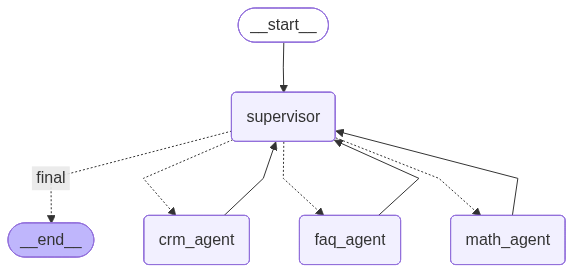

In [40]:
graph = workflow.compile()
graph

In [ ]:
# def ask_supervisor(query: str) -> str:
#     result = graph.invoke(
#         {
#             "messages": [
#                 {"role": "user", "content": query}  # ✅ LangGraph expects 'content'
#             ]
#         }
#     )
#     return result["messages"][-2].content  #catch is It’s not guaranteed that the answer will always be at [-2].



def ask_supervisor(query: str) -> str:
    result = graph.invoke(
        {"messages": [{"role": "user", "content": query}]}
    )
    messages = result["messages"]

    # Walk backwards until we find a non-empty content
    for msg in reversed(messages):
        if hasattr(msg, "content") and msg.content and msg.content.strip():
            return msg.content.strip()
    return ""   # fallback if all empty

In [56]:
ask_supervisor("what is the support email for refund policy and also explain refund policy?")

'The support email for inquiries is support@qt.com. Regarding the refund policy, customers are eligible for a refund within 30 days of their purchase, though approval may be required.'

In [57]:
ask_supervisor("what is 3 + 3 * 4 ? ")

'The result of 3 + 3 * 4 is 15. This is calculated by first multiplying 3 by 4 to get 12, and then adding 3 to 12, which equals 15.'